# CAPM Model

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [4]:
import matplotlib.pyplot as plt
import warnings

plt.style.use('seaborn')
# plt.style.use('seaborn-colorblind') #alternative
plt.rcParams['figure.figsize'] = [8, 4.5]
plt.rcParams['figure.dpi'] = 300
warnings.simplefilter(action='ignore', category=FutureWarning)

In [5]:
import pandas as pd
import yfinance as yf
import statsmodels.api as sm

In [6]:
RISKY_ASSET = 'AMZN'
MARKET_BENCHMARK = '^GSPC'
START_DATE = '2014-01-01'
END_DATE = '2018-12-31'

In [7]:
df = yf.download([RISKY_ASSET, MARKET_BENCHMARK],
                 start=START_DATE,
                 end=END_DATE,
                 adjusted=True,
                 progress=False)

print(f'Downloaded {df.shape[0]} rows of data.')

Downloaded 1258 rows of data.


In [8]:
X = df['Adj Close'].rename(columns={RISKY_ASSET: 'asset', 
                                    MARKET_BENCHMARK: 'market'}) \
                   .resample('M') \
                   .last() \
                   .pct_change() \
                   .dropna()
X.head()

,asset,market
Date,,
2014-01-31,-0.100554,-0.035583
2014-02-28,0.009507,0.043117
2014-03-31,-0.071058,0.006932
2014-04-30,-0.095847,0.006201
2014-05-31,0.027685,0.021030


In [9]:
# calculate beta using the covariance approach

covariance = X.cov().iloc[0,1]
benchmark_variance = X.market.var()
beta = covariance / benchmark_variance
beta

1.670921648924406

In [10]:
# Prepare the input and estimate CAPM as a linear regression:

# separate target
y = X.pop('asset')

# add constant
X = sm.add_constant(X)

# define and fit the regression model 
capm_model = sm.OLS(y, X).fit()

# print results 
print(capm_model.summary())

                            OLS Regression Results                            
Dep. Variable:                  asset   R-squared:                       0.381
Model:                            OLS   Adj. R-squared:                  0.370
Method:                 Least Squares   F-statistic:                     35.63
Date:                Mon, 15 Aug 2022   Prob (F-statistic):           1.53e-07
Time:                        15:48:29   Log-Likelihood:                 76.708
No. Observations:                  60   AIC:                            -149.4
Df Residuals:                      58   BIC:                            -145.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0165      0.009      1.842      0.0

These results indicate that the beta (denoted as market here) is equal to 1.67, which means that Amazon's returns are 67% more volatile than the market
(proxied by S&P 500). The value of the intercept is relatively small and statistically insignificant at the 5% significance level.

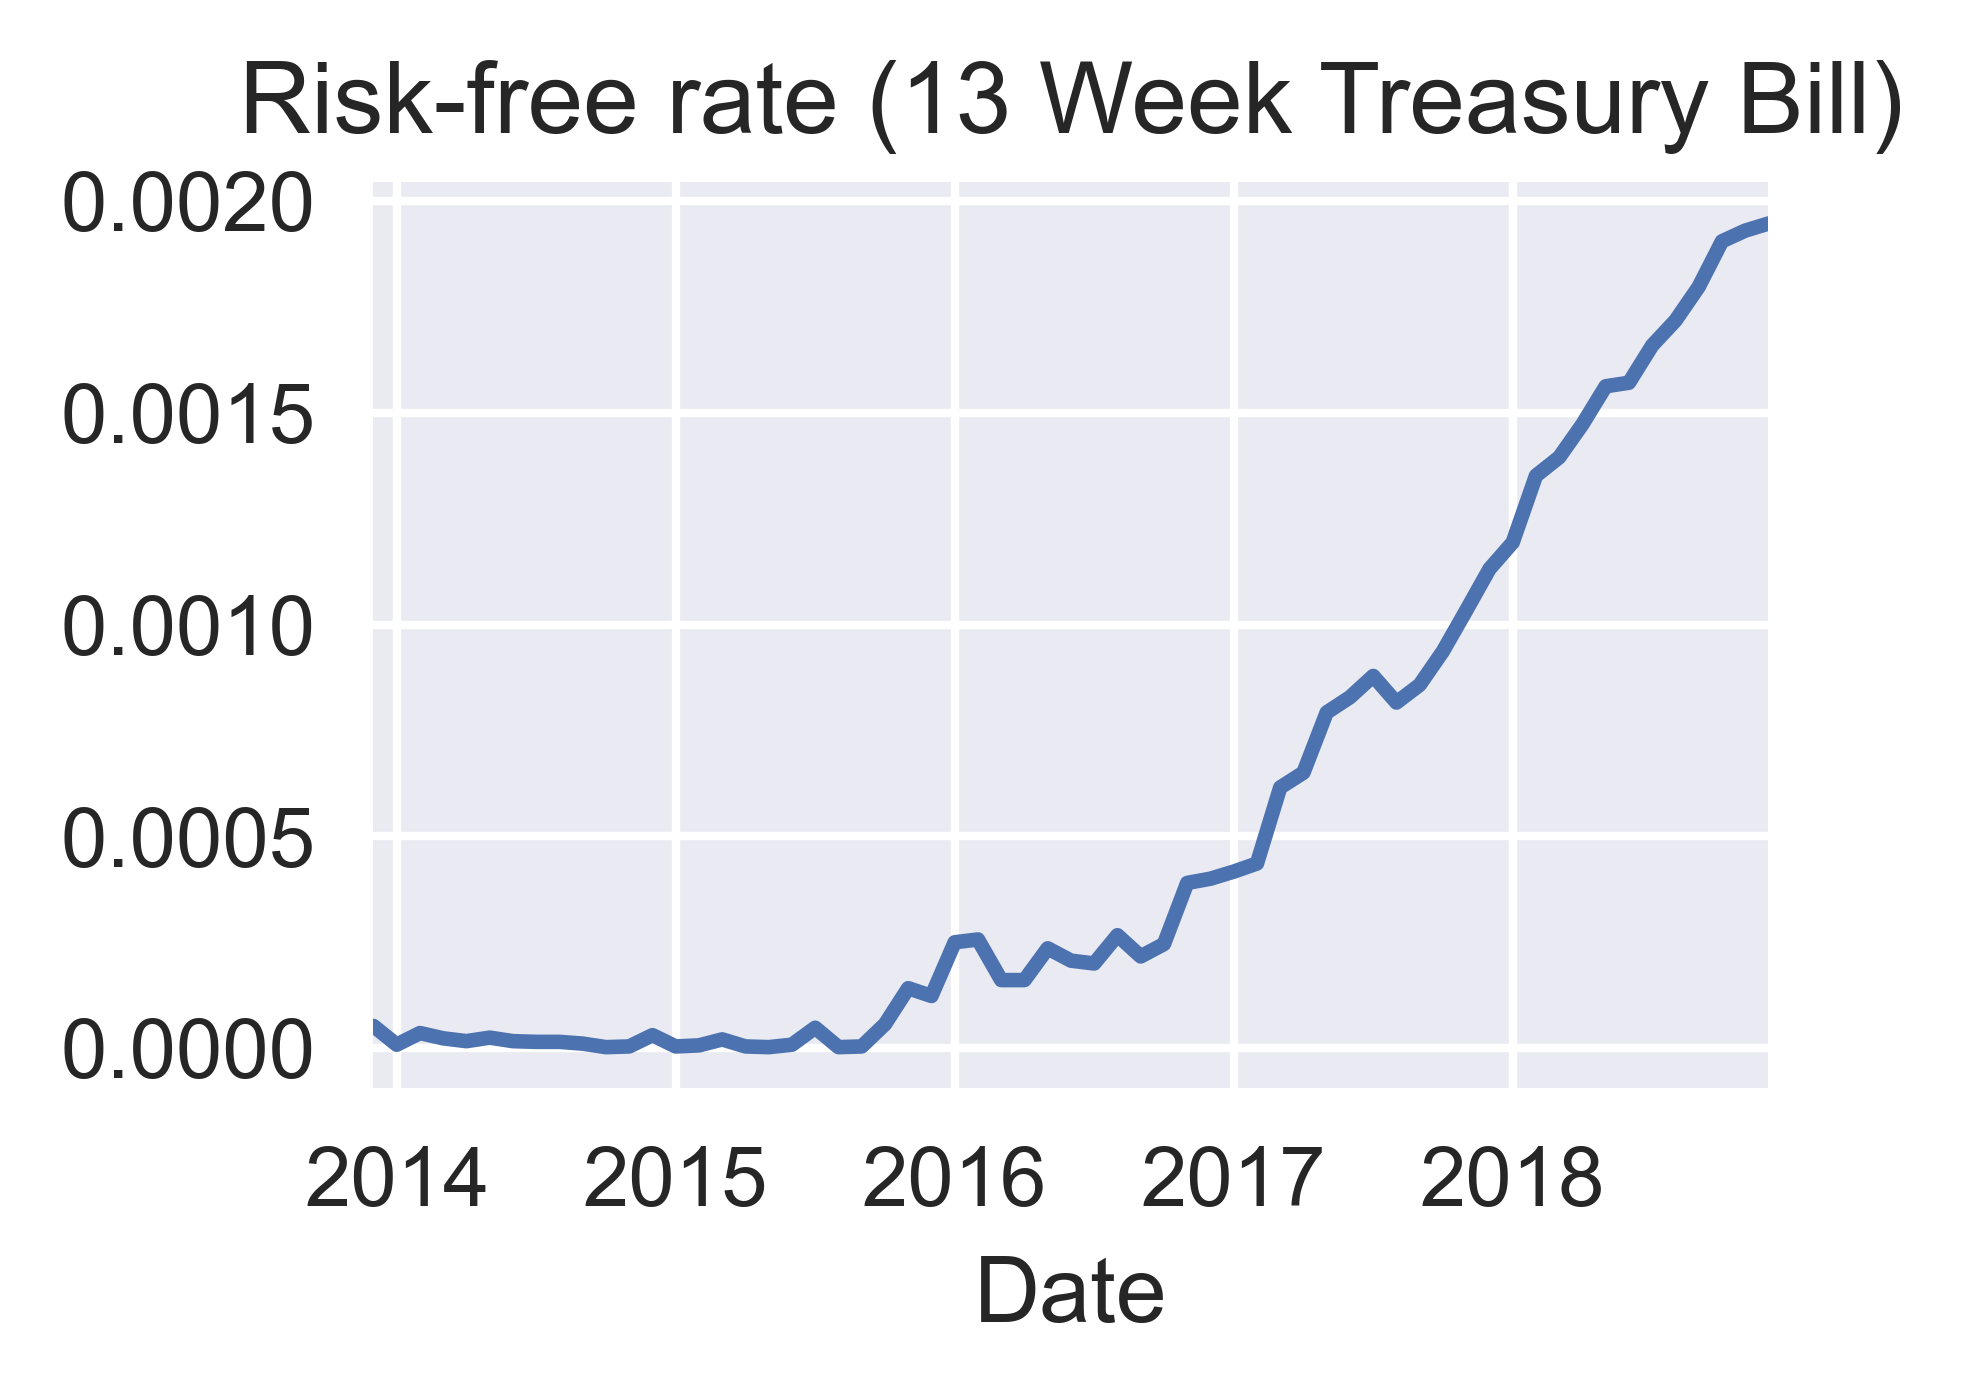

In [21]:
# Risk-free rate (13 week treasury bill)

# period lenght in days
N_DAYS = 90

# download data from Yahoo finance
df_rf = yf.download('^IRX',
                    start=START_DATE,
                    end=END_DATE,
                    progress=False)

# resample to monthly by taking last value from each month
rf = df_rf.resample('M').last().Close / 100

# calculate the corresponding daily risk-free return  
rf = ( 1 / (1 - rf * N_DAYS / 360) )**(1 / N_DAYS)  

# convert to monthly and subtract 1
rf = (rf ** 30) - 1 

# plot the risk-free rate
plt.rcParams['figure.figsize'] = (3, 2)
rf.plot(title='Risk-free rate (13 Week Treasury Bill)')

# plt.savefig('images/ch4_im2.png')
plt.show()

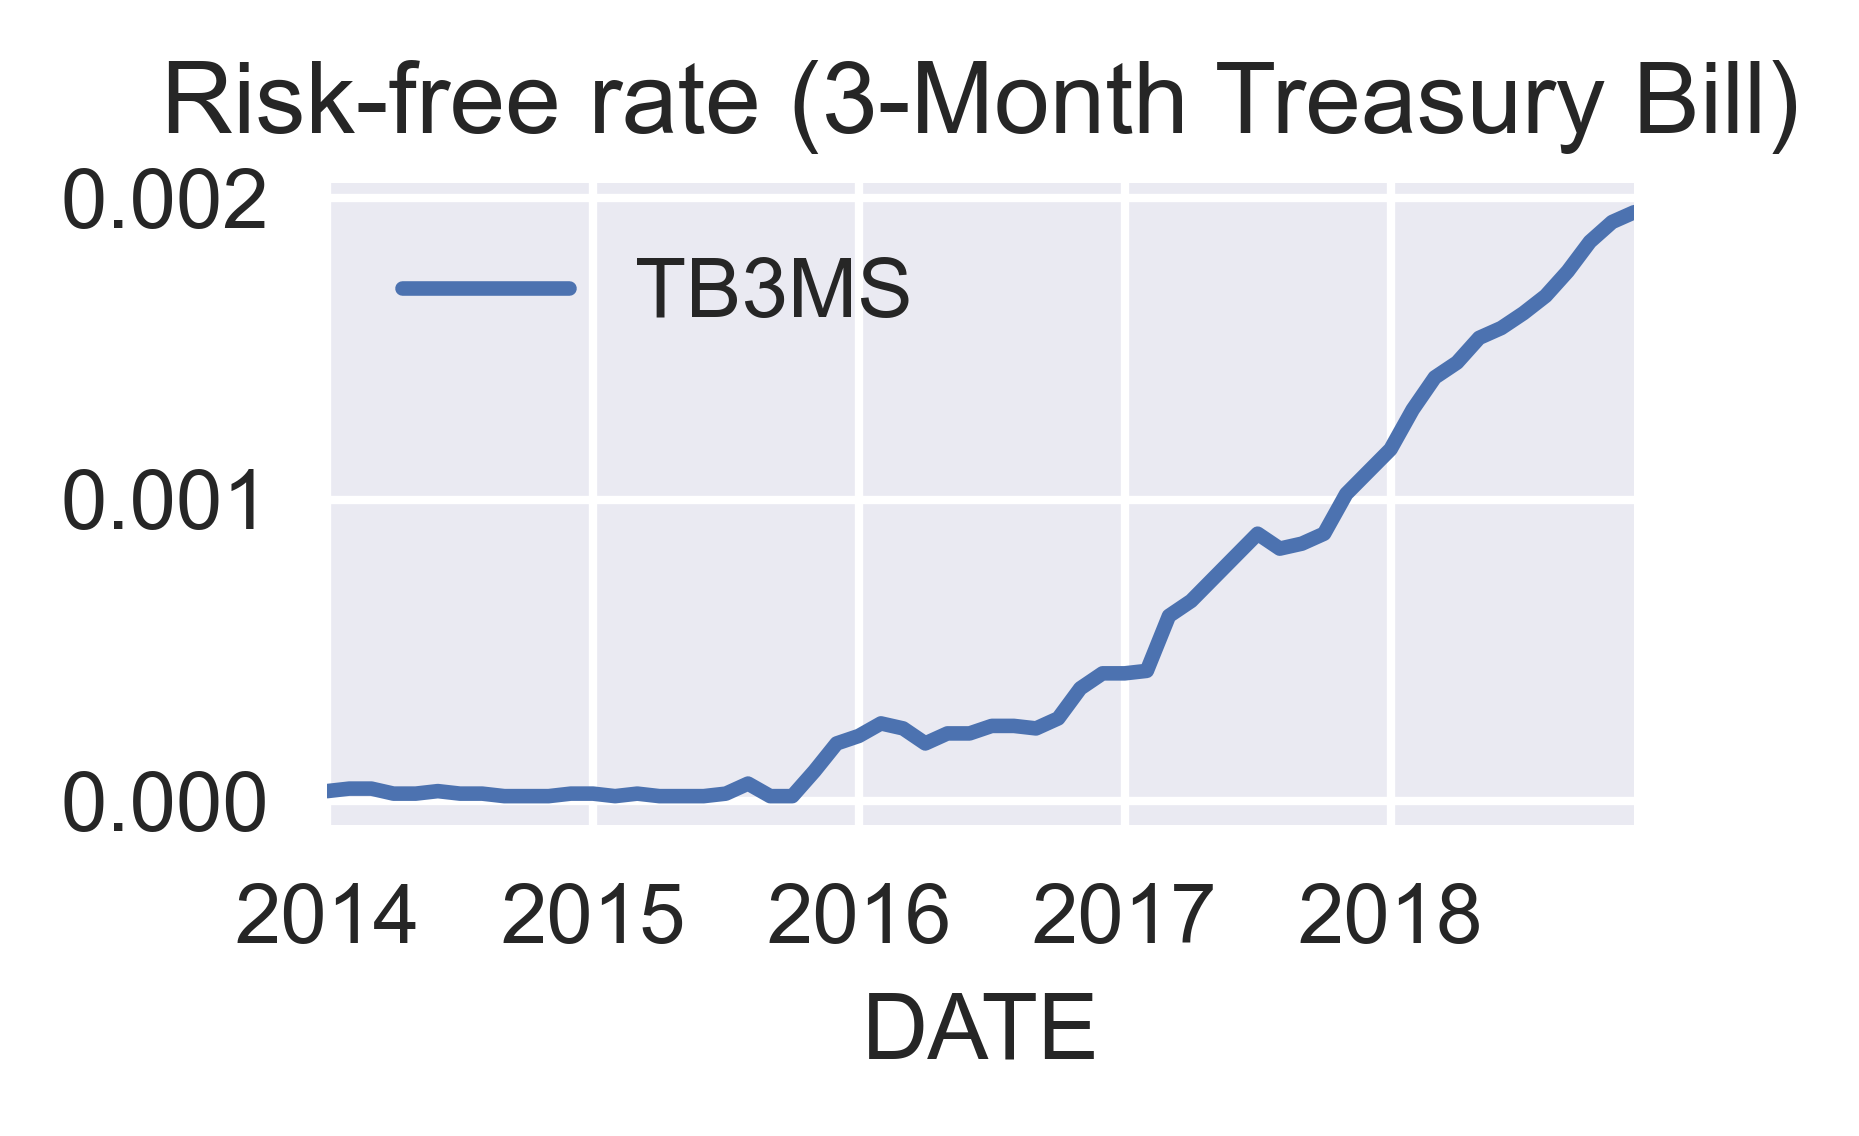

In [23]:
# Risk-free rate (3 month treasury bill)
# approximate the risk-free rate using the 3-Month Treasury Bill (Secondary Market Rate), which can be downloaded from the Federal Reserve Economic Data (FRED) database

import pandas_datareader.data as web

# download the data 
rf = web.DataReader('TB3MS', 'fred', start=START_DATE, end=END_DATE)

# convert to monthly
rf = (1 + (rf / 100)) ** (1 / 12) - 1

# plot the risk-free rate
rf.plot(title='Risk-free rate (3-Month Treasury Bill)')

plt.tight_layout()
# plt.savefig('images/ch4_im3.png')
plt.show()